# Datasets comparison between CAMS and GOME-2 (L2)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3
import subprocess # Important for GOME-2 and TROPOMI L3
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [21]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (NO2, O3, HCHO or SO2)
component_nom = 'O3'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'gome'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2021-12-01'
end_date = '2021-12-02'

# Define extent
area_name = 'Global'
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 0

# Define resolution (Minimum: 0.25x0.25)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: ('2021-12-01', '2021-12-02')
SEARCH BOUNDING BOX
Latitudes: from -90 to 0
Longitudes: from -180 to 180


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'Single', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 226, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-12-01 2021-12-02
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... -0.8 -0.4 0.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T10:23 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


In [11]:
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 226, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2021-12-01 2021-12-02
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... -0.8 -0.4 0.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] 2021-12-01 ... 2021-12-02T21:00:00
Data variables:
    component   (time, step, latitude, longitude) float32 190.0 190.0 ... 248.4
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T10:23 GRIB to CDM+CF via cfgrib-0.9.9...

### Get CAMS levels (total or tropospheric)

In [12]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be compared to the total sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 226, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2021-12-01 2021-12-02
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... -0.8 -0.4 0.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] 2021-12-01 ... 2021-12-02T21:00:00
Data variables:
    component   (time, step, latitude, longitude) float32 190.0 190.0 ... 248.4
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T10:23 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

### Download and read data as xarray

In [13]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2021-12-01:
The datasets for 2021-12-01 and METOP-A are not available.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201000103_051_METOPB_47754_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201014221_051_METOPB_47755_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201032345_051_METOPB_47756_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201050509_051_METOPB_47757_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201064627_051_METOPB_47758_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201082751_051_METOPB_47759_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201100914_051_METOPB_47760_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201115302_049_METOPB_47761_DLR_04.HDF5 was downloaded.
GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20211201133156_051_METOPB_47762_DLR_04.HDF5 was downloaded.
GOME_O3-

In [14]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, 
                              dates, satellites, lat_res, lon_res)
sensor_ds

/tmp/ipykernel_2202019/725130226.py:93: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_2202019/725130226.py:93: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.Dataset>
Dimensions:        (latitude: 180, longitude: 360, time: 2)
Coordinates:
  * latitude       (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude      (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * time           (time) datetime64[ns] 2021-12-01 2021-12-02
Data variables:
    sensor_column  (time, latitude, longitude) float64 nan nan nan ... nan nan
    delta_time     (time, latitude, longitude) datetime64[ns] NaT NaT ... NaT

## 4. Match data

In [15]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR DATE: 2021-12-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR DATE: 2021-12-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.


,latitude,longitude,sensor_column,delta_time,time,step_index,model_column
0,-89.5,-179.5,NaN,2021-12-01 12:00:00,2021-12-01,4,188.038879
1,-89.5,-178.5,NaN,2021-12-01 12:00:00,2021-12-01,4,188.050385
2,-89.5,-177.5,NaN,2021-12-01 12:00:00,2021-12-01,4,188.058136
3,-89.5,-176.5,NaN,2021-12-01 12:00:00,2021-12-01,4,188.069962
4,-89.5,-175.5,NaN,2021-12-01 12:00:00,2021-12-01,4,188.079651
...,...,...,...,...,...,...,...
32395,-0.5,175.5,243.249420,2021-12-02 21:37:50,2021-12-02,7,246.430862
32396,-0.5,176.5,245.241528,2021-12-02 21:37:50,2021-12-02,7,246.908630
32397,-0.5,177.5,244.015854,2021-12-02 21:37:50,2021-12-02,7,247.587494
32398,-0.5,178.5,247.299507,2021-12-02 21:37:50,2021-12-02,7,248.083618


## 5. Merge data and calculate difference

In [16]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column  difference  \
latitude longitude time                                                  
-89.5    -179.5    2021-12-01    188.038879            NaN         NaN   
         -178.5    2021-12-01    188.050385            NaN         NaN   
         -177.5    2021-12-01    188.058136            NaN         NaN   
         -176.5    2021-12-01    188.069962            NaN         NaN   
         -175.5    2021-12-01    188.079651            NaN         NaN   
...                                     ...            ...         ...   
-0.5      175.5    2021-12-02    246.430862     243.249420   -3.181442   
          176.5    2021-12-02    246.908630     245.241528   -1.667102   
          177.5    2021-12-02    247.587494     244.015854   -3.571640   
          178.5    2021-12-02    248.083618     247.299507   -0.784111   
          179.5    2021-12-02    248.646805            NaN         NaN   

                               relative_difference  
latitude longitude time                             
-89.5    -179.5    2021-12-01                  NaN  
         -178.5    2021-12-01                  NaN  
         -177.5    2021-12-01                  NaN  
         -176.5    2021-12-01                  NaN  
         -175.5    2021-12-01                  NaN  
...                                            ...  
-0.5      175.5    2021-12-02             0.013079  
          176.5    2021-12-02             0.006798  
          177.5    2021-12-02             0.014637  
          178.5    2021-12-02             0.003171  
          179.5    2021-12-02                  NaN  

[64800 rows x 4 columns]

In [17]:
descr_stats_table = merge_df.describe()
descr_stats_table

,model_column,sensor_column,difference,relative_difference
count,64800.000000,55182.000000,55182.000000,55182.000000
mean,272.254712,274.124326,0.703961,-0.003673
std,46.755961,46.592570,6.566825,0.024021
min,161.878799,164.830574,-88.953979,-0.220683
25%,248.964214,248.297912,-3.063170,-0.017466
50%,279.961166,281.240518,0.743655,-0.002722
75%,303.487511,306.673827,4.391024,0.010667
max,375.171265,381.444519,78.363257,0.331553


## 6. Show comparison plots

### Select plot dates

In [18]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2021-12-01' '2021-12-02']


### Select plot extent

In [19]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 0))


### Compare CAMS and GOME-2 total columns

In [22]:
# Choose distribution (aggregated, individual, seasonal or animated)
distribution_type = 'animated'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection=ccrs.Orthographic(180, -90)
color_scale = ['jet', 'jet', 'seismic']

# Get and decide the best width and height of the B/W frame lines (it only applies to ccrs.PlateCarree())
width_lon, height_lat = None, None

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.10, 
                          model_type, sensor_type, range_type, distribution_type, projection, 
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual)

2022-01-13 10:37:10,136 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


2022-01-13 10:37:12,249 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-01-13 10:37:12,255 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x720 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y animation.gif


## 7. Retrieve nearest values to specific coordinates

model_column  \
region       lat_search lon_search latitude longitude time                       
Antartica    -80.00      30.00     -80.5     29.5     2021-12-01    179.233307   
                                                      2021-12-02    173.131104   
Sydney       -33.80      151.70    -33.5     151.5    2021-12-01    297.988312   
                                             149.5    2021-12-02    289.952789   
Buenos Aires -34.61     -58.46     -34.5    -58.5     2021-12-01    302.704010   
                                                      2021-12-02    296.833282   

                                                                  sensor_column  \
region       lat_search lon_search latitude longitude time                        
Antartica    -80.00      30.00     -80.5     29.5     2021-12-01     178.296402   
                                                      2021-12-02     174.707251   
Sydney       -33.80      151.70    -33.5     151.5    2021-12-01     300.116257   
                                             149.5    2021-12-02     286.483398   
Buenos Aires -34.61     -58.46     -34.5    -58.5     2021-12-01     303.277045   
                                                      2021-12-02     290.628621   

                                                                  difference  \
region       lat_search lon_search latitude longitude time                     
Antartica    -80.00      30.00     -80.5     29.5     2021-12-01   -0.936905   
                                                      2021-12-02    1.576147   
Sydney       -33.80      151.70    -33.5     151.5    2021-12-01    2.127945   
                                             149.5    2021-12-02   -3.469391   
Buenos Aires -34.61     -58.46     -34.5    -58.5     2021-12-01    0.573035   
                                                      2021-12-02   -6.204661   

                                                                  relative_difference  
region       lat_search lon_search latitude longitude time                             
Antartica    -80.00      30.00     -80.5     29.5     2021-12-01             0.005255  
                                                      2021-12-02            -0.009022  
Sydney       -33.80      151.70    -33.5     151.5    2021-12-01            -0.007090  
                                             149.5    2021-12-02             0.012110  
Buenos Aires -34.61     -58.46     -34.5    -58.5     2021-12-01            -0.001889  
                                                      2021-12-02             0.021349

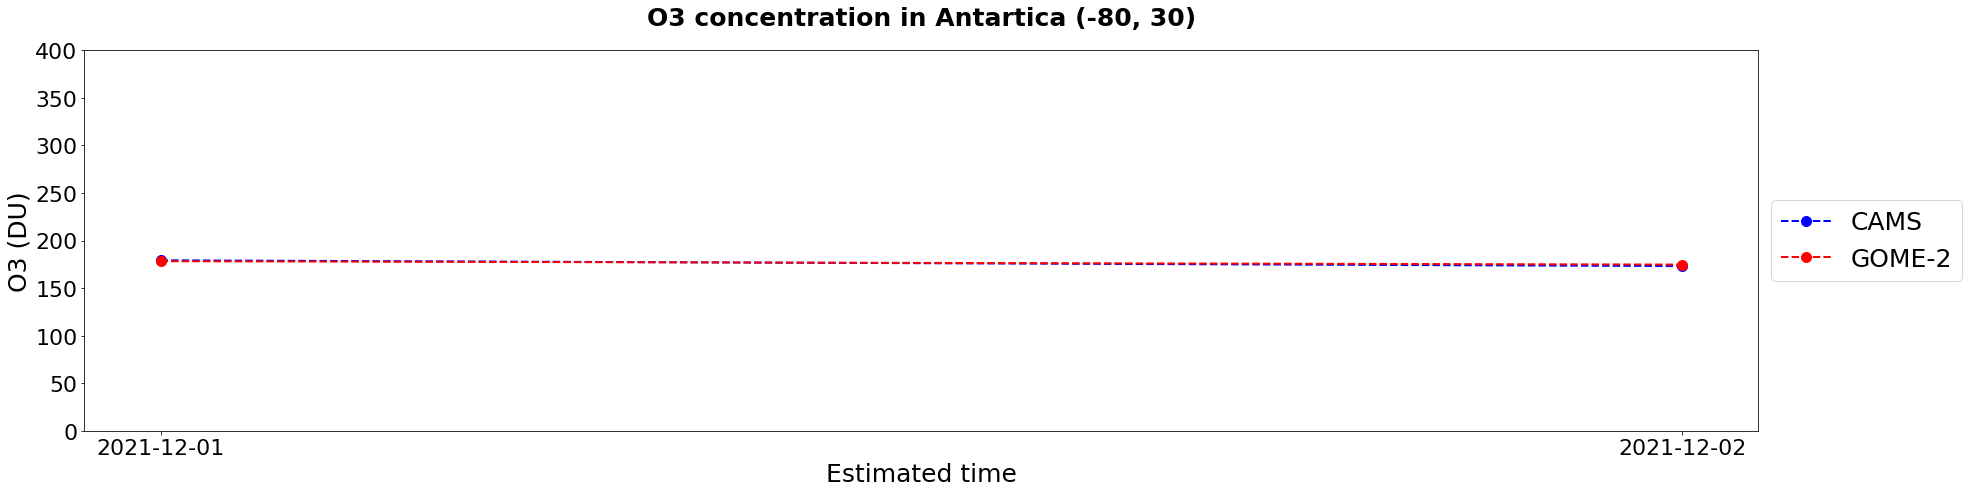

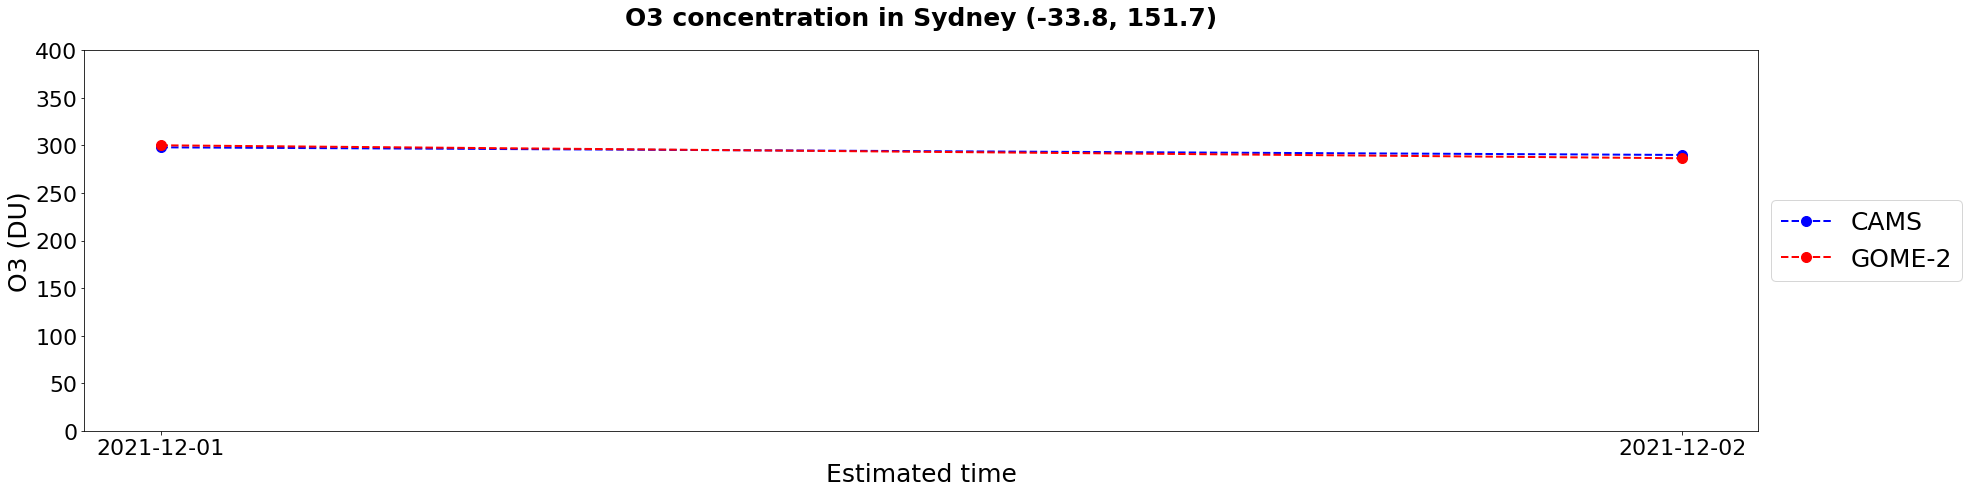

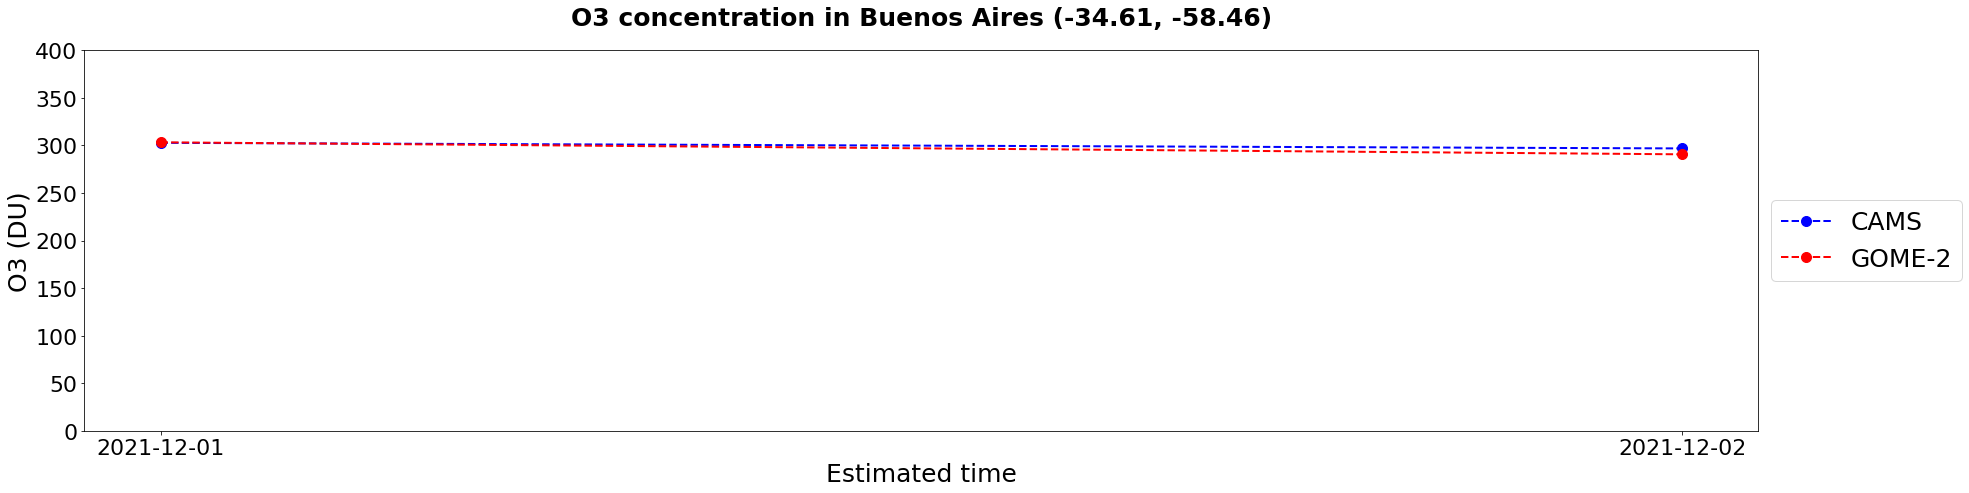

In [23]:
regions_names = ('Antartica', 'Sydney', 'Buenos Aires')
coords_list = (-80, 30,
               -33.8, 151.7,
               -34.61, -58.46)
ymin = 0
ymax = 400
xticks = plot_dates

timeseries_table = timeseries(merge_df.dropna(), component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

## 8. Scatter plots by bbox

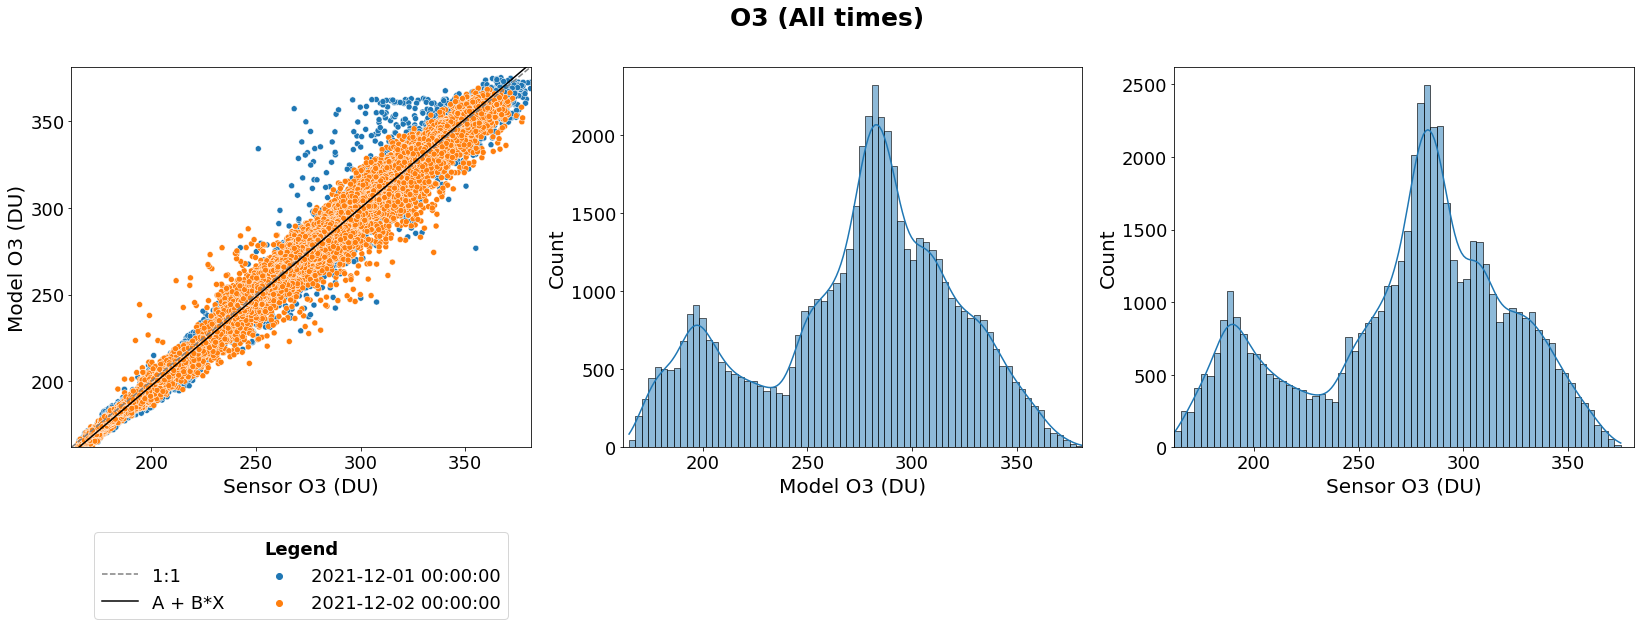

,Period,Location,A,B,R2,RMSE,MSE
0,"[2021-12-01T00:00:00.000000000, 2021-12-02T00:...","((-180, -90), (180, 0))",1.026598,-7.995005,0.982147,6.448774,41.586692


In [24]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 9. Scatter plots by season

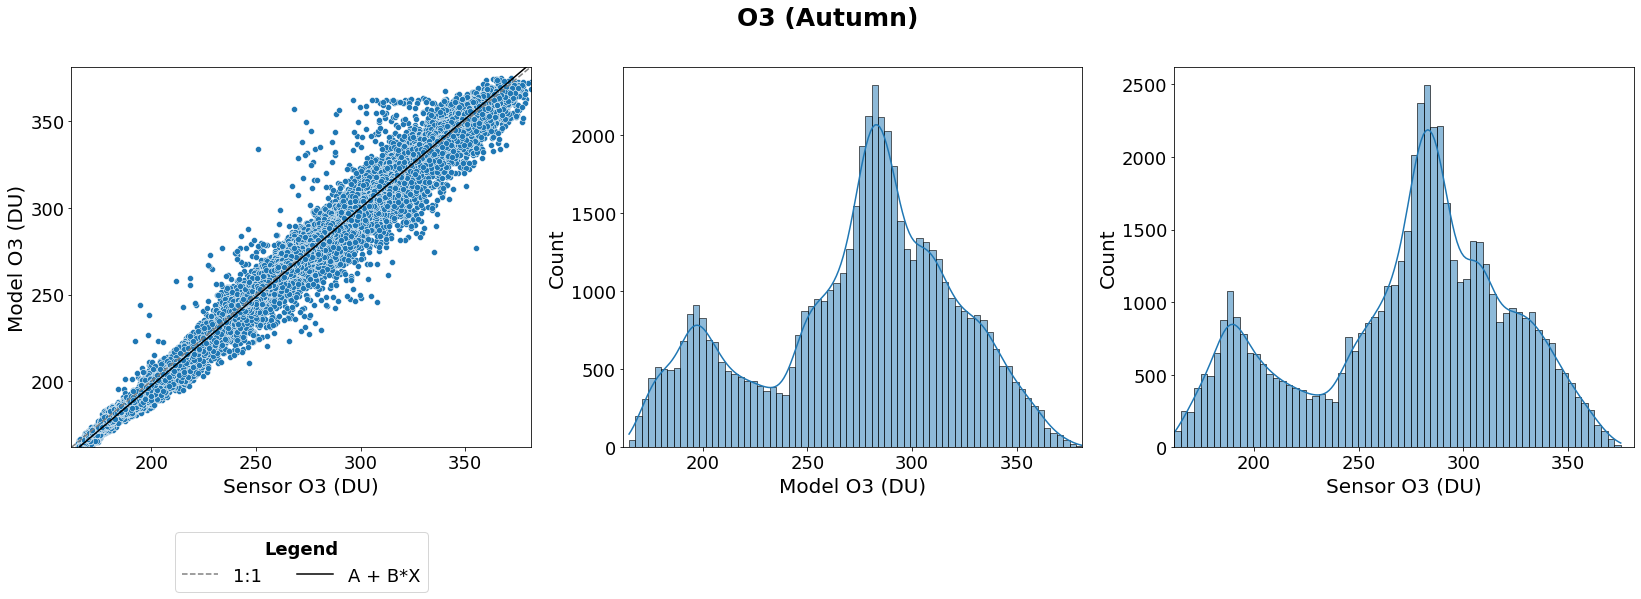

,Period,Location,A,B,R2,RMSE,MSE
0,Autumn,"((-180, -90), (180, 0))",1.026598,-7.995005,0.982147,6.448774,41.586692


In [25]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 10. Scatter plots by country (Google API required!)

In [26]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['Argentina', 'Chile', 'Australia']

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['Argentina', 'Chile', 'Australia']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\nsummary\n"